In [3]:
import os
import shutil
import random

# Define paths
source_folder = "/kaggle/input/real-fake-fourier/fake_fourier/fake_fourier"
destination_folder = "/kaggle/working/real_vs_fake"

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Create test, train, and valid folders within destination folder
folders = ['test', 'train', 'valid']
for folder in folders:
    os.makedirs(os.path.join(destination_folder, folder, 'real'), exist_ok=True)

# List all images in source folder
images = os.listdir(source_folder)
random.shuffle(images)

# Calculate the number of images for each category
total_images = len(images)
test_count = 5000
train_count = int(0.8 * (total_images - test_count))
valid_count = total_images - test_count - train_count

# Move images to respective folders
for folder, count in [('test', test_count), ('train', train_count), ('valid', valid_count)]:
    for i in range(count):
        image = images.pop()
        shutil.copy(os.path.join(source_folder, image), os.path.join(destination_folder, folder, 'real'))

# Copy train, valid, and test folders to real_vs_fake
# for folder in folders:
#     shutil.copytree(os.path.join(destination_folder, folder), os.path.join(destination_folder, 'real_vs_fake', folder))


In [4]:
# Define paths
source_folder = "/kaggle/input/real-fake-fourier/real_fourier/real_fourier"
destination_folder = "/kaggle/working/real_vs_fake"

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Create test, train, and valid folders within destination folder
folders = ['test', 'train', 'valid']
for folder in folders:
    os.makedirs(os.path.join(destination_folder, folder, 'fake'), exist_ok=True)

# List all images in source folder
images = os.listdir(source_folder)
random.shuffle(images)

# Calculate the number of images for each category
total_images = len(images)
test_count = 5000
train_count = int(0.8 * (total_images - test_count))
valid_count = total_images - test_count - train_count

# Move images to respective folders
for folder, count in [('test', test_count), ('train', train_count), ('valid', valid_count)]:
    for i in range(count):
        image = images.pop()
        shutil.copy(os.path.join(source_folder, image), os.path.join(destination_folder, folder, 'fake'))

# Copy train, valid, and test folders to real_vs_fake
# for folder in folders:
#     shutil.copytree(os.path.join(destination_folder, folder), os.path.join(destination_folder, 'real_vs_fake', folder))


In [5]:
def count_files(folder_path):
    # Initialize count
    file_count = 0

    # Walk through the folder and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

In [6]:
# Specify the folder path
folders = ['test', 'train', 'valid']
folder_path = 'real_vs_fake/'

for i in folders:
    print("Number of files in fake/"+str(i)+" :", count_files(folder_path+i+'/fake'))

Number of files in fake/test : 5000
Number of files in fake/train : 20000
Number of files in fake/valid : 5000


In [7]:
# Specify the folder path
folders = ['test', 'train', 'valid']
folder_path = 'real_vs_fake/'

for i in folders:
    print("Number of files in real/"+str(i)+" :", count_files(folder_path+i+'/real'))

Number of files in real/test : 5754
Number of files in real/train : 20000
Number of files in real/valid : 5000


In [8]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm
import keras

2024-05-16 01:50:44.994166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 01:50:44.994286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 01:50:45.120071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
base_path = 'real_vs_fake/'
image_gen = ImageDataGenerator(rescale=1./255)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 40000 images belonging to 2 classes.


In [10]:
image_gen1 = ImageDataGenerator(rescale=1./255)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 10000 images belonging to 2 classes.


In [11]:
image_gen1 = ImageDataGenerator(rescale=1./255.)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 10754 images belonging to 2 classes.


In [12]:
def build_model(pretrained, learning_rate=0.0001):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )

    return model

In [13]:
densenet = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Stop training if no improvement after 3 epochs
checkpoint = ModelCheckpoint('DenseNetImagenetFourier.model.keras', monitor='val_loss', save_best_only=True)  # Save the best model

In [15]:
history = model.fit(
    train_flow,
    epochs = 5,
    validation_data =valid_flow,
    callbacks=[checkpoint]
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715824462.477511     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 775s 928ms/step - accuracy: 0.8641 - auc: 0.9357 - loss: 0.3161 - precision: 0.8466 - recall: 0.8946 - val_accuracy: 0.5856 - val_auc: 0.9406 - val_loss: 1.1491 - val_precision: 0.9703 - val_recall: 0.1766
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 524s 831ms/step - accuracy: 0.9663 - auc: 0.9942 - loss: 0.0918 - precision: 0.9627 - recall: 0.9694 - val_accuracy: 0.9474 - val_auc: 0.9883 - val_loss: 0.1368 - val_precision: 0.9538 - val_recall: 0.9404
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 550s 872ms/step - accuracy: 0.9846 - auc: 0.9988 - loss: 0.0431 - precision: 0.9836 - recall: 0.9857 - val_accuracy: 0.9568 - val_auc: 0.9914 - val_loss: 0.1114 - val_precision: 0.9552 - val_recall: 0.9586
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 480s 760ms/step - accuracy: 0.9883 - auc: 0.9993 - loss: 0.0315 - precision: 0.9878 - recall: 0.9888 - val_accuracy: 0.9121 - val_auc: 0.9822 - val_loss: 0.2752 - val_precision: 0.9847 - val_recall: 0.8372
Epoch 5/5
625/625 ━━━━━━━━━━━━

In [16]:
import pickle
with open('trainHistoryDenseNetImagenetFourier.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

<Figure size 1200x600 with 0 Axes>

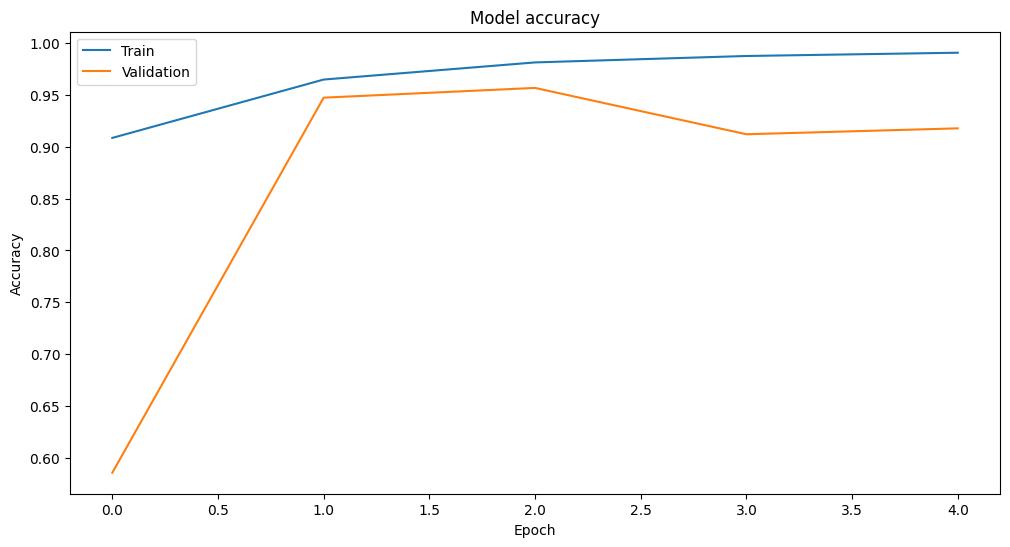

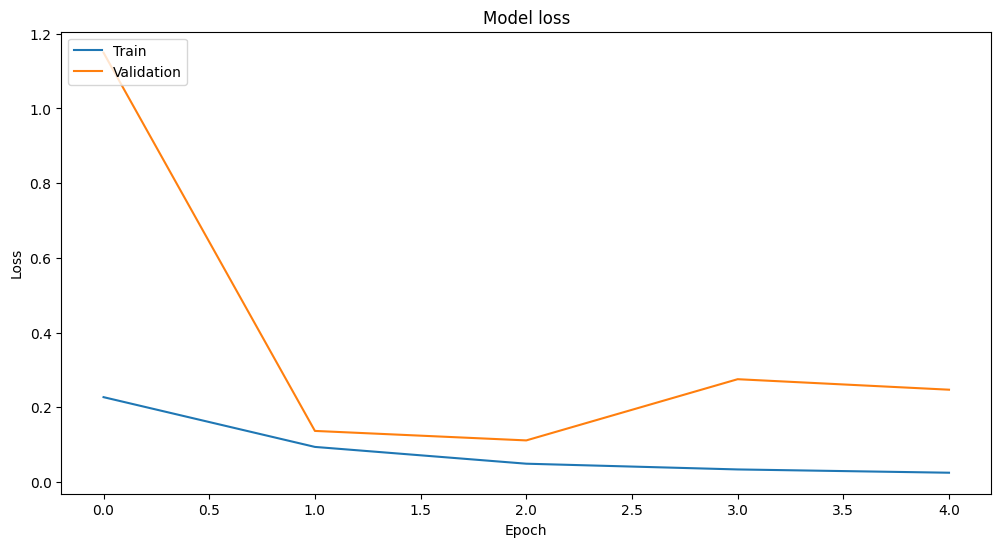

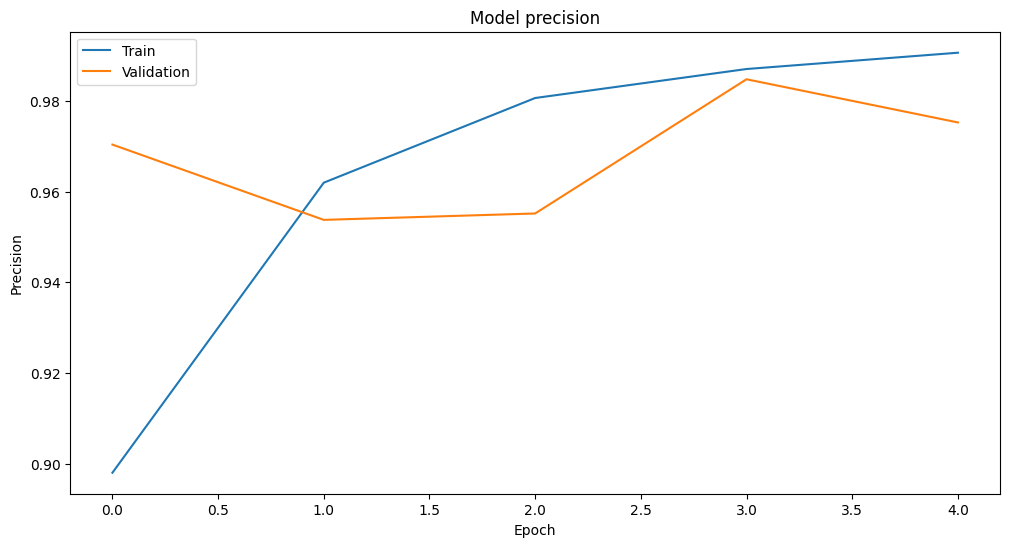

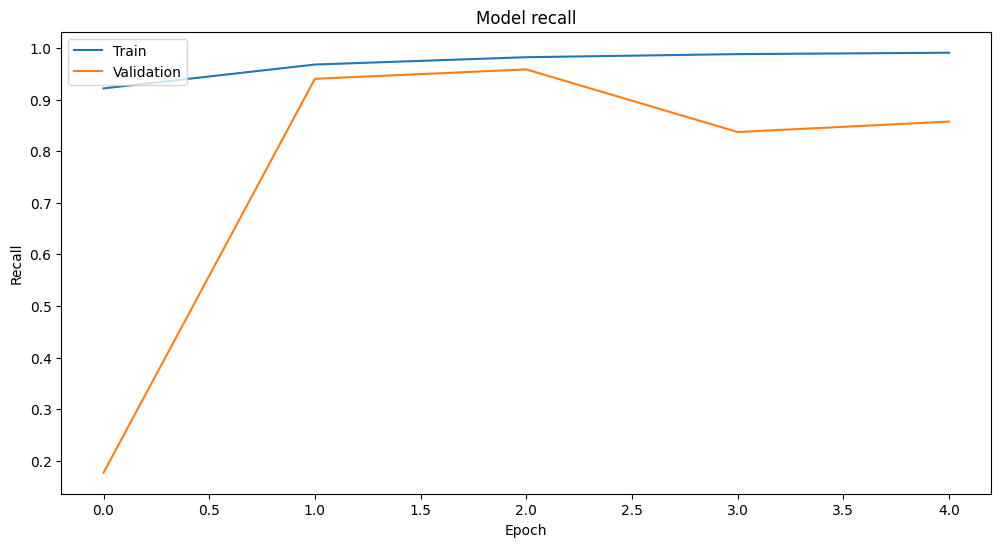

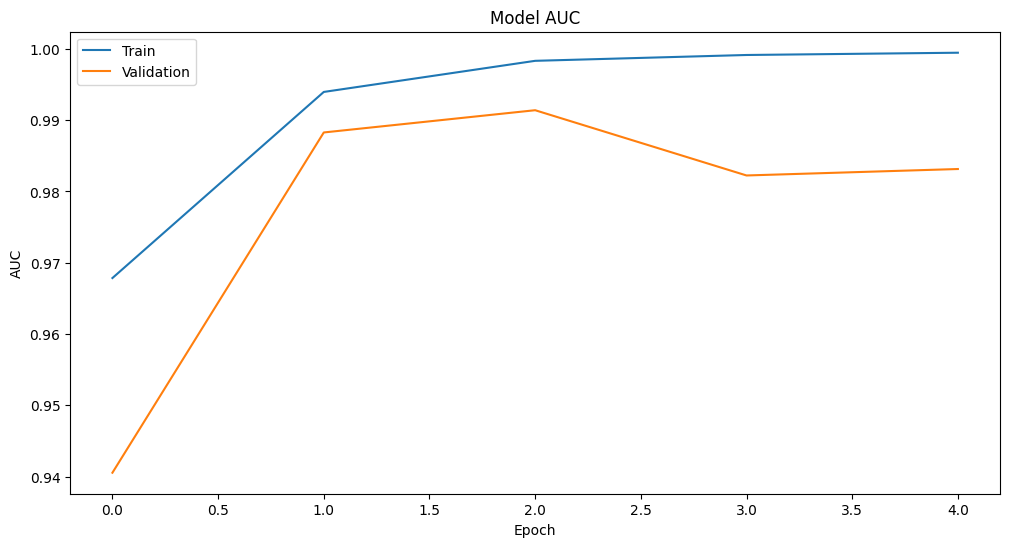

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, accuracy_score

# Accuracy and loss history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.figure(figsize=(12, 6))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation AUC values
plt.figure(figsize=(12, 6))
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
loss, accuracy, auc, precision, recall = model.evaluate(test_flow)

In [19]:
# Get true labels from the test_flow
y_test = test_flow.classes

# Predict using the model
y_pred_prob = model.predict(test_flow, steps=test_flow.samples // test_flow.batch_size + 1)
y_pred = (y_pred_prob > 0.5).astype(int)  # Assuming binary classification with a threshold of 0.5

# Flatten y_pred if necessary
y_pred = y_pred.ravel()

# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

111/169 ━━━━━━━━━━━━━━━━━━━━ 34s 600ms/step

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7dbe788f81d0>
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 250, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 244, in generator_fn
    yield self.py_dataset[i]

  File "/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/opt/conda/lib/python3.10/site-packages/PIL/Image.py", line 3298, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7dbe788f81d0>


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 